In [ ]:
# demo: loads file with all messages (CSTARTTIME, CSENDERENDPOINTID, ymdhm )
# show some charts, anomaly detection with LSTM autoencoders

In [250]:
import base.dfBasics as dfBasics
import base.common as common
import base.encoder as encoder
import base.pfAdapt as pfAdapt
import base.charts as charts
import base.anomaly as anomaly

import pandas as pd    
from pyspark.sql import functions

In [251]:
sparkSession = dfBasics.getSparkSession()
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/sla/CSENDERENDPOINTID/CSENDERENDPOINTID_9.parquet')
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/sla/sla_1580137124017.parquet')
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/sla/sla_1616754087742.parquet')
#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/CSENDERENDPOINTID/CSENDERENDPOINTID_2191.parquet')
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/CSENDERENDPOINTID_full/CSENDERENDPOINTID_9.parquet')
pfall = df.toPandas() 

In [252]:
CSENDERENDPOINTID=9

In [253]:
## Setup charts
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

def get_ym_string(a,b) :
    return a + "-" + b
    #return a.join(["-",b]) 

def get_ym(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    return a,b

def get_ymd(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    return a,b,c

def make_2digits(blist):
    for n, b in enumerate(blist):
        if int(b) < 10:
             blist[n] = '0' + str(b)
    return blist

def get_ymd_string(a,b,c) :
    if isinstance(a, str) :
        return a + "-" + make_2digits([b])[0] + "-" + make_2digits([c])[0] 
    return a + "-" + pd.Index(make_2digits(b.tolist())) + "-" + pd.Index(make_2digits(c.tolist())) 

def get_ymdh(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    d = mdcountsall.index.get_level_values(3).astype(str)
    return a,b,c,d

def get_ymdh_string(a,b,c,d) :
    return a + "-" + b + "-" + c + "-" + d

def createData_ym(pfall,month) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month'])['year'].count()    
    a,b = get_ym(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ym_string(a,b)
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def createData(pfall,month,year=2020) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['year'] == year) & (pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day','hour'])['year'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['outcome'] =  mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int)

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    return data2


def createData_ymd(pfall,month,year=2020) :
    if (month > 0) & (month < 13) :
        mdcountsall = pfall[(pfall['year'] == year) & (pfall['month'] == month)].groupby(['year','month','day'])['year'].count()
    else :
        mdcountsall = pfall.groupby(['year','month','day'])['year'].count()    
    a,b,c = get_ymd(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymd_string(a,b,c)
    data2['year'] = a.astype(int) 
    data2['month'] = b.astype(int) 
    data2['day'] = c.astype(int) 
    data2['outcome'] = mdcountsall.reset_index(level=0, drop=True).reset_index()['year'].astype(int) 
    return data2

def label(graph,skip,rot) :
    for ind, label in enumerate(graph.get_xticklabels()):
        if ind % skip == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(rot)
        else:
            label.set_visible(False)

def createBarplot(md=None,fx=24,fy=12,fontscale=3.0,title="") :
    sns.set(style='whitegrid', palette='muted', font_scale=fontscale)
    plt.figure(figsize=(fx,fy))
    plt.title(title)
    ax = sns.barplot(x=md['date'], y=md['outcome'], data=md)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=75 )
    plt.tight_layout()
    plt.show()
    return ax

## heatmap
def createHeatmap(piv,title="") :
    plt.figure(figsize=(24,8))
    plt.title(title)
    ax = sns.heatmap(piv, square=True)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
    plt.tight_layout()
    plt.show()
    return ax

Setup Complete


In [254]:
make_2digits([4])

['04']

In [ ]:
pfall1 = pfall.sort_values(['year','month','day','hour']).reset_index()
del pfall1['index']
del pfall1['CGLOBALMESSAGEID']

In [258]:
pfall.columns


Index(['CGLOBALMESSAGEID', 'year', 'month', 'day', 'hour', 'CSTATUS',
       'CSERVICE', 'CSENDERPROTOCOL', 'CINBOUNDSIZE', 'CRECEIVERPROTOCOL',
       'CRECEIVERENDPOINTID', 'CSLATAT', 'CMESSAGETAT2', 'CSLADELIVERYTIME'],
      dtype='object')

In [ ]:
CRECEIVERENDPOINTID=725

In [ ]:
pfall0 = pfall[pfall['CRECEIVERENDPOINTID']==725]
pda = createData_ymd(pfall0,0)

In [ ]:
def check_complete(year=2020):
    for m in range(1, 13):
        #print(m)
        mm = pda[(pda['month'] == m) & (pda['year'] == year)]
        print(m,monthrange(year, m)[1] == len(mm))

def fill(pda,year,month):        
    days = monthrange(year, month)[1]
    df = pda[(pda['month'] == month) & (pda['year'] == year)]
    for day in range(1, days + 1):
        if len(df[df['day']==day]) == 0:
            pda.loc[len(pda)]=[get_ymd_string(str(year),str(month),str(day)),year,month,day,0]
    

In [ ]:
def unique(pfall):
    return pd.unique(pfall['CRECEIVERENDPOINTID']), pd.unique(pfall['CSTATUS']), pd.unique(pfall['CSERVICE']), pd.unique(pfall['CSENDERPROTOCOL']), pd.unique(pfall['CRECEIVERPROTOCOL'])

#un=unique(pfall)
#unique(pfall[pfall['CRECEIVERENDPOINTID']==725])

#pfall0 = pfall[pfall['CRECEIVERENDPOINTID']==un[0][1]]
#pda = createData_ymd(pfall0,0)

#del pda['index'] 

In [ ]:
from calendar import monthrange

def get_month(pda, year=2020, month=1):
    return pda[(pda['month'] == month) & (pda['year'] == year)]

def is_complete(pda, year=2020, month=1):
    mm = pda[(pda['month'] == month) & (pda['year'] == year)]
    if len(mm) > 0:
        return monthrange(year, month)[1] == len(mm)
    return None
    
def check_complete(pda, year=2020):
    for m in range(1, 13):
        mm = pda[(pda['month'] == m) & (pda['year'] == year)]
        if len(mm) > 0:
            print(m,monthrange(year, m)[1] == len(mm))

#pda :  date,year,month,day.outcome 
def fill(pda,year,month):        
    days = monthrange(year, month)[1]
    df = pda[(pda['month'] == month) & (pda['year'] == year)]
    for day in range(1, days + 1):
        if len(df[df['day']==day]) == 0:
            #print(day)
            pda.loc[len(pda)]=[get_ymd_string(str(year),str(month),str(day)),year,month,day,0]
            
def check(_res):
    _start_year = min(pd.unique(_res['year']))
    _end_year = max(pd.unique(_res['year']))  
    _start_month = min(pd.unique(_res[_res['year']== _start_year]['month']))
    _end_month = max(pd.unique(_res[_res['year']== _end_year]['month']))

    _end = 13
    for year in range(_start_year,_end_year+1):
        for month in range(_start_month,_end):
            print(year,month)
            fill(_res,year,month)
        _start_month=1
        if year == (_end_year-1):
            _end = _end_month + 1     
            
#check(pda)  
pda = pda.sort_values(['date']).reset_index()   

In [ ]:
del pda['index'] 

In [ ]:
fill(pda,2019,11)     
fill(pda,2019,12) 
fill(pda,2020,1)
fill(pda,2020,2)
fill(pda,2020,3)
fill(pda,2020,4)
fill(pda,2020,5)
fill(pda,2020,6)
fill(pda,2020,7)
fill(pda,2020,8)
fill(pda,2020,9)
fill(pda,2020,10)
fill(pda,2020,11)
fill(pda,2020,12)
fill(pda,2021,1)
fill(pda,2021,2)
fill(pda,2021,3)
pda = pda.sort_values(['date']).reset_index()

In [ ]:
pfall1 = pda

In [ ]:
pda
md = createData_ym(pfall,0)
ax=createBarplot(md,24,12,3.0,title="number messages sent by all endpoints")

In [ ]:
md

In [ ]:
md2 = createData_ymd(pfall,3,year=2020)
ax=createBarplot(md2,fx=24,fy=12,fontscale=3.0,title="number messages sent by all endpoints")
label(ax,1000,90)

In [ ]:
# pfall[(pfall['year'] == year) & (pfall['month'] == month)].groupby(['year','month','day','hour'])['year'].count()
md2['outcome'].sum()    

In [ ]:
class Time(object):         
    def __init__(self,year=None,month=None,day=None):
        self.year  = self._int_value(year)
        self.month = self._int_value(month)
        self.day   = self._int_value(day)
    
    def _int_value(self,value):
        if value == '' or value == None:
            return None
        return int(value)
        

class TimeRange(object):    
    def __init__(self,dataframe=None,year_from=None,month_from=None,day_from=None,year_to=None,month_to=None,day_to=None):
        if dataframe is None:
            self.start = Time(year=year_from,month=month_from,day=day_from).__dict__
            self.end   = Time(year_to,month_to,day_to).__dict__
        else:
            #print(dataframe)
            year_from = min(pd.unique(dataframe['year']))
            year_to = max(pd.unique(dataframe['year']))  
            month_from = min(pd.unique(dataframe[dataframe['year']== year_from]['month']))
            month_to = max(pd.unique(dataframe[dataframe['year']== year_to]['month']))
            day_from = min(pd.unique(dataframe[(dataframe['year']== year_from) & (dataframe['month'] == month_from)]['day']))
            day_to = max(pd.unique(dataframe[(dataframe['year']== year_to) & (dataframe['month'] == month_to)]['day']))
            self.start = Time(year_from,month_from,day_from).__dict__
            self.end   = Time(year_to,month_to,day_to).__dict__
            
#TimeRange(dataframe=pfall).__dict__  

def set_date_widget_value(element, value):
    if value != None:
        element.value = str(value)
    else:
        element.value = ''

def init_date_widget(_res):
    _range = TimeRange(dataframe=_res)
    set_date_widget_value(year_from, _range.start['year'])
    set_date_widget_value(month_from, _range.start['month'])
    set_date_widget_value(day_from, _range.start['day'])
    
    set_date_widget_value(year_to, _range.end['year'])
    set_date_widget_value(month_to, _range.end['month'])
    set_date_widget_value(day_to, _range.end['day'])
    
    
  

In [ ]:
def createHeatmapPfall(pfall=pfall,sender='all',month=1,year=2020):
    #print(month,year)
    global data2
    global piv
    data2 = createData(pfall,month,year=year)
    piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
    #titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category + " so far = " + str(topsender.iloc[7]['outcome']) + " , month: " + str(month) 
    #titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category  + " month: " + str(month) 
    titlestring ="number messages " + str(year) + "-" + str(month) + "  " + sender
    sns.set(style='whitegrid', palette='muted', font_scale=1.2)
    createHeatmap(piv, titlestring)

createHeatmapPfall(pfall=pfall,sender='all',month=1,year=2020)

In [ ]:
def on_value_submit_month(change):
    #adapt_all()    
    sender=0
   
    with out:
        clear_output()
        month=int(month_from.value)
        year=int(year_from.value)
        createHeatmapPfall(pfall0,"endpoint " + str(CSENDERENDPOINTID) + ' --> ' + str(CRECEIVERENDPOINTID),month=month, year=year)
        #print(int(month_from.value), year_from.value)
        #createHeatmapPfall(pfall=pfall,sender='all',month=1,year=2020)
        
        md2 = createData_ymd(pfall0,month,year=year)
        ax=createBarplot(md2,fx=24,fy=12,fontscale=3.0,title="number messages " + "endpoint " + str(CSENDERENDPOINTID) + ' --> ' + str(CRECEIVERENDPOINTID))
        label(ax,1000,90)

In [ ]:
layout2 = {'width': '400px'}

year_from   = widgets.Text(description = 'year',value = '2020', style=style, layout=layout2,disabled=False)   
year_to     = widgets.Text(description = 'to',value = '', style={'description_width': '20px'}, layout={'width': '200px'},disabled=False)  
#year_hbox = widgets.HBox([year_from,year_to])
year_hbox = widgets.HBox([year_from])

#month  = widgets.Text(description = 'month',value = '', style=style, layout=layout,disabled=False) 
month_from   = widgets.Text(description = 'month',value = '1', style=style, layout=layout2,disabled=False)   
month_to     = widgets.Text(description = 'to',value = '', style={'description_width': '20px'}, layout={'width': '200px'},disabled=False)  
#month_hbox   = widgets.HBox([month_from,month_to])
month_hbox   = widgets.HBox([month_from])

day_from   = widgets.Text(description = 'day',value = '', style=style, layout=layout2,disabled=False)   
day_to     = widgets.Text(description = 'to',value = '', style={'description_width': '20px'}, layout={'width': '200px'},disabled=False)  
day_hbox   = widgets.HBox([day_from,day_to])

month_from.on_submit(on_value_submit_month)
year_from.on_submit(on_value_submit_month)

out = widgets.Output()

display (year_hbox,month_hbox,out)
#init_date_widget(pfall)  

In [ ]:
#data2
#TimeRange(dataframe=pfall).__dict__
_pf = pfall.drop_duplicates(subset=['month','day','year'])
#_pf[(_pf['month'] == 1) & (_pf['year'] == 2020)]
_pf = pfall[['month','day','year']].drop_duplicates()

_days = len(_pf[(_pf['month'] == 10) & (_pf['year'] == 2019)]) \
+ len(_pf[(_pf['month'] == 11) & (_pf['year'] == 2019)]) \
+ len(_pf[(_pf['month'] == 12) & (_pf['year'] == 2019)]) \
+ len(_pf[(_pf['month'] == 1) & (_pf['year'] == 2020)]) \
+ len(_pf[(_pf['month'] == 2) & (_pf['year'] == 2020)]) \
+ 18 , len(_pf)
_days[0] / _days[1]

In [ ]:
TimeRange(dataframe=pfall).__dict__

In [ ]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# new

In [ ]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

# Time Series Anomaly Detection with LSTM Autoencoders (selected sender)

In [ ]:
# %%capture
import AnomalyDetectionLSTMAutoencoder
anomalyEnc2 = AnomalyDetectionLSTMAutoencoder.AnomalyDetectionLSTMAutoencoder(TIME_STEPS = 30)
anomalyEnc2.initAndTrain(pfall1,0.7)

anomalyEnc1 = AnomalyDetectionLSTMAutoencoder.AnomalyDetectionLSTMAutoencoder(TIME_STEPS = 30)
anomalyEnc1.initAndTrain(pfall1,0.262)

In [ ]:
len(pfall1),  len(anomalyEnc.train), len(anomalyEnc.test), len(anomalyEnc.y_test), len(anomalyEnc.df1), len(anomalyEnc.train), len(anomalyEnc.test),anomalyEnc.TIME_STEPS, len(anomalyEnc.X_train), len(anomalyEnc.y_train)

In [ ]:
# %%capture
import numpy as np

#anomalyEnc.test_score_df      = anomalyEnc.testScoreDF(anomalyEnc.model, 0.0, anomalyEnc.X_test, anomalyEnc.test)

#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
#data = plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.loss, label='loss')

#y=plt.getp(data[0],'ydata')

#threshold_X = 0.98 * np.max(y)
#threshold_X = np.max(y) - 0.0001
#anomalyEnc.evaluateAnomalies(threshold_X)

In [ ]:
import ipywidgets as widgets
style = {'description_width': '250px'}
layout = {'width': '600px'}
from IPython.display import display, clear_output

def getThreshold(perc):
    anomalyEnc.test_score_df      = anomalyEnc.testScoreDF(anomalyEnc.model, 0.0, anomalyEnc.X_test, anomalyEnc.test)
    fig = plt.figure(figsize=(12,6))
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    data = plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.loss, label='loss')
    y=plt.getp(data[0],'ydata')
    plt.show(fig)
    
    #threshold_X = np.max(y) - 0.025
    return perc * np.max(y)

out2 = widgets.Output()
with out2:
    threshold_X = getThreshold(0.88)
    
threshold_X    

anomalyEnc.evaluateAnomalies(threshold_X)

In [ ]:
def scatterplot(index, values,label):
    return sns.scatterplot(
      x=index,
      y=values,
      color=sns.color_palette()[3],
      s=152,
      label=label
    )
    
def plot_test(test,scaler,anomalies,titlestring,xlabel):

    fig = plt.figure(figsize=(18,9))
    
    plt.plot(
      test[anomalyEnc.TIME_STEPS:].index, 
      #scaler.inverse_transform(test[TIME_STEPS:].close), 
      scaler.inverse_transform(test[anomalyEnc.TIME_STEPS:]),   
      label='msg count'
    );

    #ax = scatterplot(anomalyEnc.anomalies.index, anomalyEnc.scaler.inverse_transform(anomalyEnc.anomalies['close']), 'anomaly')  
    #ax = scatterplot(anomalyEnc.anomalies.index, anomalyEnc.scaler.inverse_transform(anomalyEnc.anomalies), 'anomaly')
    _a=anomalyEnc.anomalies['close']
    _a = pd.DataFrame(_a)
    _a = anomalyEnc.scaler.inverse_transform(_a)
    _a = _a[:, 0]
    #print(_a,type(_a),_a[0],len(_a),len(_a[:, 0]))
    ax = scatterplot(anomalyEnc.anomalies.index, _a, 'anomaly') 
    
    ax.set_xlabel(xlabel)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
    plt.xticks(rotation=25)
    plt.legend();

    label(ax,5,80)
    plt.title(titlestring)
    plt.show(fig)


In [ ]:
out3 = widgets.Output()

def models_on_change(change):
    global anomalyEnc
    if change['type'] == 'change' and change['name'] == 'value':
        #print(change['new'])
        if change['new'] == 1:
            anomalyEnc = anomalyEnc1
        else:
            anomalyEnc = anomalyEnc2

def on_value_submit_percent(change):
    with out2:
        global threshold_X
        threshold_X = getThreshold(float(percent.value))
        anomalyEnc.evaluateAnomalies(threshold_X)
        clear_output()
    
    with out3:
        clear_output()
        sender = 0
        #titlestring ="endpoint (sending) : " + str(sender) + " ( trained: " +  anomalyEnc.train.index[0] + " -- " + anomalyEnc.train.index[len(anomalyEnc.train.index)-1] + " )"
        #plot_test(anomalyEnc.test,anomalyEnc.scaler,anomalyEnc.anomalies,titlestring)
        
        #fig = plt.figure(figsize=(12,6))
        #plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
        
        # threshold
        #plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.loss, label='loss')
        #plt.plot(anomalyEnc.test_score_df.index, anomalyEnc.test_score_df.threshold, label='threshold')
        
        sender = CSENDERENDPOINTID
        receiver = CRECEIVERENDPOINTID
        titlestring ="endpoint " + str(CSENDERENDPOINTID) + ' --> ' + str(CRECEIVERENDPOINTID) + " ( trained: " +  anomalyEnc.train.index[0] + " -- " + anomalyEnc.train.index[len(anomalyEnc.train.index)-1] + " )"
        _xlabel = 'date: ' + anomalyEnc.test.index[0] + ' -- ' + anomalyEnc.test.index[len(anomalyEnc.test) -1]
        plot_test(anomalyEnc.test,anomalyEnc.scaler,anomalyEnc.anomalies,titlestring, _xlabel)
        display(anomalyEnc.anomalies)
        
        #plt.show(fig)
        
percent   = widgets.Text(description = 'percent',value = '0.985', style=style, layout=layout,disabled=False)    
percent.on_submit(on_value_submit_percent)

models = widgets.Dropdown(description='model',options =[1,2], style=style, layout=layout,disabled=False)
models.observe(models_on_change) 

anomalyEnc = anomalyEnc1
display(models,percent,out3)

# Demo

In [246]:
pfall0

,CGLOBALMESSAGEID,year,month,day,hour,CSTATUS,CSERVICE,CSENDERPROTOCOL,CINBOUNDSIZE,CRECEIVERPROTOCOL,CRECEIVERENDPOINTID,CSLATAT,CMESSAGETAT2,CSLADELIVERYTIME
0,6878249240966155692,2020,1,15,5,11,5,0,2293,0,725,6159,7495,1579063677504
1,-3549930604559515972,2020,1,15,5,11,5,0,2293,0,725,6239,7205,1579063703375
2,7294079960648046876,2020,1,15,7,11,5,0,2445,0,725,227454,276896,1579071191028
3,4593600892465465186,2020,1,15,9,11,5,0,2359,0,725,6285,40731,1579076545891
4,-1466978904100060073,2020,1,15,10,11,5,0,854,0,725,6160,43341,1579081703258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782420,-7897740044678644349,2020,4,5,22,11,5,0,614,0,725,5640,5790,1586117600585
1782421,-6783699335817719085,2020,4,5,22,11,5,0,30549,0,725,4485,4637,1586117117778
1782422,3176671547071877123,2020,4,5,22,11,5,0,599,0,725,5185,5324,1586117624175
1782423,-541979808772834438,2020,4,5,22,11,5,0,602,0,725,4661,4804,1586117595455


{'start': {'year': 2019, 'month': 10, 'day': 29}, 'end': {'year': 2021, 'month': 4, 'day': 7}}


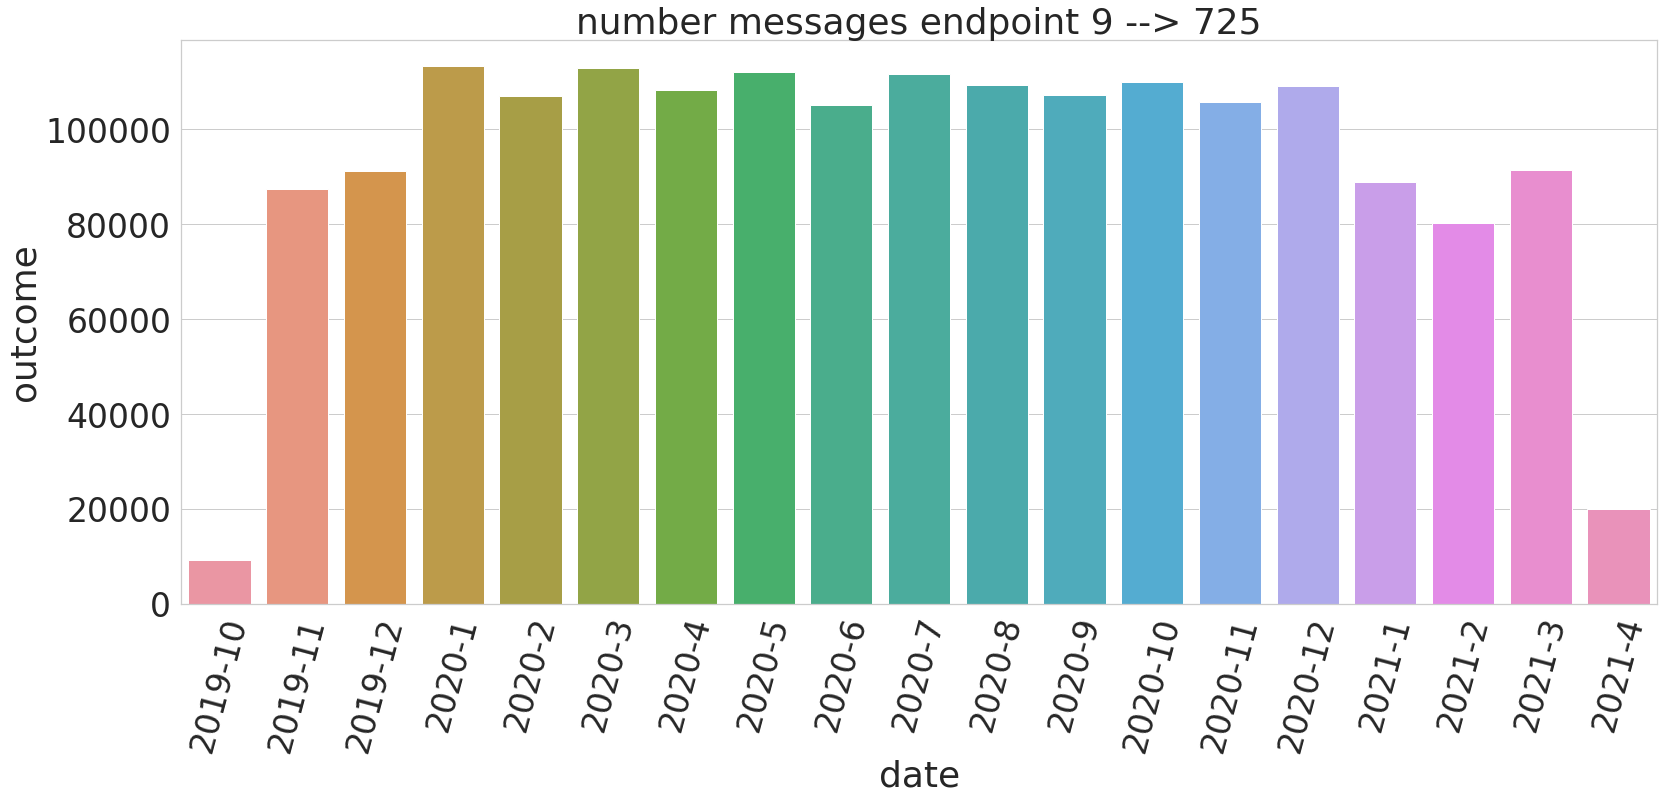

In [247]:
print(TimeRange(dataframe=pfall).__dict__)
md = createData_ym(pfall0,0)
ax=createBarplot(md,24,12,3.0,title="number messages " +  "endpoint " + str(CSENDERENDPOINTID) + ' --> ' + str(CRECEIVERENDPOINTID))

In [248]:
display (year_hbox,month_hbox,out)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1728x576 with 2 Axes>', '…

In [249]:
percent   = widgets.Text(description = 'percent',value = '0.985', style=style, layout=layout,disabled=False)    
percent.on_submit(on_value_submit_percent)

models = widgets.Dropdown(description='model',options =[1,2], style=style, layout=layout,disabled=False)
models.observe(models_on_change) 

anomalyEnc = anomalyEnc1
display(models,percent,out3)

Dropdown(description='model', layout=Layout(width='600px'), options=(1, 2), style=DescriptionStyle(description…

Text(value='0.985', description='percent', layout=Layout(width='600px'), style=DescriptionStyle(description_wi…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 1296x648 with 1 Axes>', '…